In [34]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rodrigorosasilva/cic-ddos2019-30gb-full-dataset-csv-files")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Sanjjey Arumugam\.cache\kagglehub\datasets\rodrigorosasilva\cic-ddos2019-30gb-full-dataset-csv-files\versions\1


In [ ]:
import os, glob

files = glob.glob(os.path.join(path, "**/*.csv"), recursive=True)
print("Total CSV files:", len(files))
print("Sample files:")
for f in files[:10]:
    print(f)


In [46]:
import pandas as pd

csv_path = Dataset_path

# load only first 50k rows to start
df = pd.read_csv(csv_path,low_memory=False, nrows=50000)
print(df.shape)
df.head()
print(df.columns)
print(df[" Label"].unique()[:20])   # note: some files have a leading space before "Label"
df = df.rename(columns={" Label": "Label"})
df["label_bin"] = df["Label"].apply(lambda x: 0 if str(x).lower()=="benign" else 1)
print(df["label_bin"].value_counts())
drop_cols = [c for c in df.columns if df[c].dtype=="object" and c not in ["Label"]]
df = df.drop(columns=drop_cols)
# Drop non-numeric columns
df = df.select_dtypes(include=[np.number])

# Replace inf values with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Fill NaN with column median
df = df.fillna(df.median())


(50000, 88)
Index(['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Mi

Initial shape: (200000, 88)
After cleaning: (190708, 83)
Class distribution before balancing:
Label
1    188975
0      1733
Name: count, dtype: int64
Class distribution after SMOTE:
Label
1    151180
0    151180
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       347
           1       1.00      1.00      1.00     37795

    accuracy                           1.00     38142
   macro avg       1.00      1.00      1.00     38142
weighted avg       1.00      1.00      1.00     38142


Confusion Matrix:
[[  346     1]
 [    0 37795]]


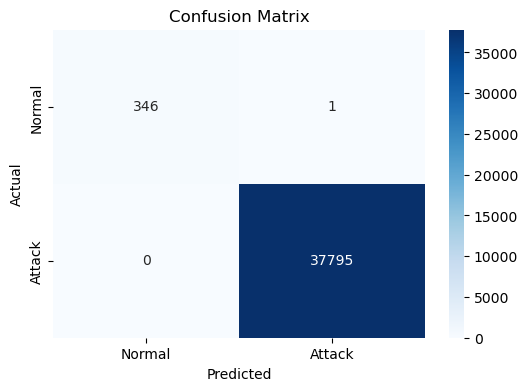

In [50]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

chunksize = 50000
chunk_list = []
for i, chunk in enumerate(pd.read_csv(csv_path, chunksize=chunksize, low_memory=False)):
    if i > 3:   # first 200k rows
        break
    chunk_list.append(chunk)

df = pd.concat(chunk_list, ignore_index=True)
print("Initial shape:", df.shape)

# --------------------------
# Step 3: Cleaning
# --------------------------
df = df.dropna(axis=1, how="all")      # drop empty cols
df = df.dropna()                       # drop rows with NaN
df = df.loc[:, ~df.columns.duplicated()]  # drop duplicate cols

# Encode labels
df[" Label"] = df[" Label"].str.strip()
df["Label"] = df[" Label"].apply(lambda x: 0 if "BENIGN" in x.upper() else 1)
df = df.drop(columns=[" Label"])

# Keep only numeric
df = df.select_dtypes(include=[np.number])

# Handle inf / -inf values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

print("After cleaning:", df.shape)

# --------------------------
# Step 4: Features + Target
# --------------------------
X = df.drop("Label", axis=1)
y = df["Label"]

print("Class distribution before balancing:")
print(y.value_counts())

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --------------------------
# Step 5: Scale features safely
# --------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float64))  # force float64
X_test = scaler.transform(X_test.astype(np.float64))

# --------------------------
# Step 6: SMOTE balancing
# --------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

# --------------------------
# Step 7: Train RandomForest
# --------------------------
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

# --------------------------
# Step 8: Evaluation
# --------------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

THE ABOVE CONFUSION MATRIX IS BASED ON THE ORIGINAL DATASET'S TRAIN & TEST SPLIT, NOT AFTER USE SMOTE SO IT LOOKS LIKE THERE IS A CLASS IMBALANCE BUT IN THE DATASET THE MODEL IS TRAINED ON IS CLASS-BALANCED DATASET USING SMOTE

In [ ]:
joblib.dump(clf, "dns_ddos_model.pkl")


Fold 1:
Class distribution after SMOTE:
 Label
1    151180
0    151180
Name: count, dtype: int64
Accuracy: 0.9999737821823711
Confusion Matrix:
 [[  347     0]
 [    1 37794]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       347
           1       1.00      1.00      1.00     37795

    accuracy                           1.00     38142
   macro avg       1.00      1.00      1.00     38142
weighted avg       1.00      1.00      1.00     38142


Fold 2:
Class distribution after SMOTE:
 Label
1    151180
0    151180
Name: count, dtype: int64
Accuracy: 0.9999213465471134
Confusion Matrix:
 [[  344     3]
 [    0 37795]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       347
           1       1.00      1.00      1.00     37795

    accuracy                           1.00     38142
   macro avg       1.00      1.00      1.00     38142

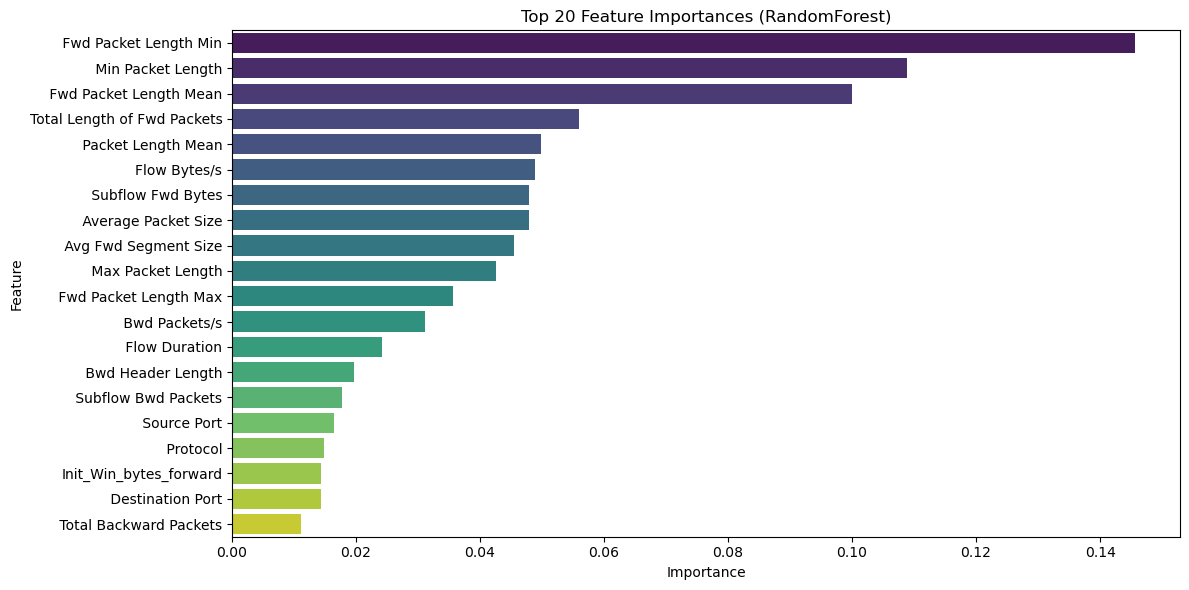

In [53]:

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
# ---------------------------
# Apply SMOTE (only on training folds, not before CV!)
# ---------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
acc_scores = []
reports = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Balance only the training data
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

    print(f"\nFold {fold}:")
    print("Class distribution after SMOTE:\n", y_train_bal.value_counts())

    # Train model
    clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    clf.fit(X_train_bal, y_train_bal)

    # Predictions
    y_pred = clf.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    acc_scores.append(acc)
    reports.append(classification_report(y_test, y_pred, output_dict=True))

    print("Accuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    fold += 1

# ---------------------------
# Average Results Across Folds
# ---------------------------
print("\nAverage CV Accuracy:", np.mean(acc_scores))

# ---------------------------
# Train final model on full balanced dataset
# ---------------------------
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

final_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
final_model.fit(X_bal, y_bal)

# ---------------------------
# Feature Importance
# ---------------------------
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
sns.barplot(x=importances[indices][:20], y=X.columns[indices][:20], palette="viridis")
plt.title("Top 20 Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Initial shape: (200000, 88)
After cleaning: (190708, 83)
Dropping identifier-like features: []
Class distribution before balancing:
Label
1    188975
0      1733
Name: count, dtype: int64
Class distribution after SMOTE:
Label
1    151180
0    151180
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       347
           1       1.00      1.00      1.00     37795

    accuracy                           1.00     38142
   macro avg       1.00      1.00      1.00     38142
weighted avg       1.00      1.00      1.00     38142


Confusion Matrix:
[[  346     1]
 [    0 37795]]


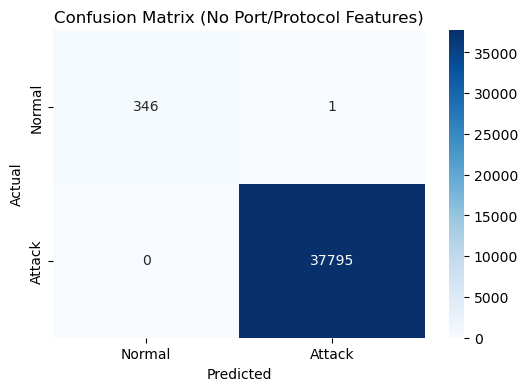

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

# --------------------------
# Step 1: Load subset of dataset (first 200k rows in chunks)
# --------------------------
chunksize = 50000
chunk_list = []
for i, chunk in enumerate(pd.read_csv(csv_path, chunksize=chunksize, low_memory=False)):
    if i > 3:   # ~200k rows
        break
    chunk_list.append(chunk)

df = pd.concat(chunk_list, ignore_index=True)
print("Initial shape:", df.shape)

# --------------------------
# Step 2: Cleaning
# --------------------------
df = df.dropna(axis=1, how="all")          # drop empty cols
df = df.dropna()                           # drop rows with NaN
df = df.loc[:, ~df.columns.duplicated()]   # drop duplicate cols

# Encode labels
df[" Label"] = df[" Label"].str.strip()
df["Label"] = df[" Label"].apply(lambda x: 0 if "BENIGN" in x.upper() else 1)
df = df.drop(columns=[" Label"])

# Keep only numeric
df = df.select_dtypes(include=[np.number])

# Handle inf/-inf
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

print("After cleaning:", df.shape)

# --------------------------
# Step 3: Drop identifier-like features
# --------------------------
drop_cols = [c for c in ["Source Port", "Destination Port", "Protocol"] if c in df.columns]
print("Dropping identifier-like features:", drop_cols)
df = df.drop(columns=drop_cols)

# --------------------------
# Step 4: Features + Target
# --------------------------
X = df.drop("Label", axis=1)
y = df["Label"]

print("Class distribution before balancing:")
print(y.value_counts())

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --------------------------
# Step 5: Scaling
# --------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float64))
X_test = scaler.transform(X_test.astype(np.float64))

# --------------------------
# Step 6: SMOTE Balancing
# --------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

# --------------------------
# Step 7: Train RandomForest
# --------------------------
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

# --------------------------
# Step 8: Evaluation
# --------------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (No Port/Protocol Features)")
plt.show()
